
🎯 Accuracy PLSDA : 0.91
🎯 Accuracy Random Forest : 0.96

📋 Rapport PLSDA :
                 precision    recall  f1-score   support

         canola       1.00      1.00      1.00        11
         kochia       1.00      1.00      1.00         7
        ragweed       0.67      0.89      0.76         9
redroot_pigweed       1.00      1.00      1.00         8
        soybean       1.00      1.00      1.00         3
      sugarbeet       0.88      0.64      0.74        11
      waterhemp       1.00      1.00      1.00         7

       accuracy                           0.91        56
      macro avg       0.93      0.93      0.93        56
   weighted avg       0.92      0.91      0.91        56


📋 Rapport Random Forest :
                 precision    recall  f1-score   support

         canola       1.00      1.00      1.00        11
         kochia       0.88      1.00      0.93         7
        ragweed       1.00      1.00      1.00         9
redroot_pigweed       1.00      0.75  

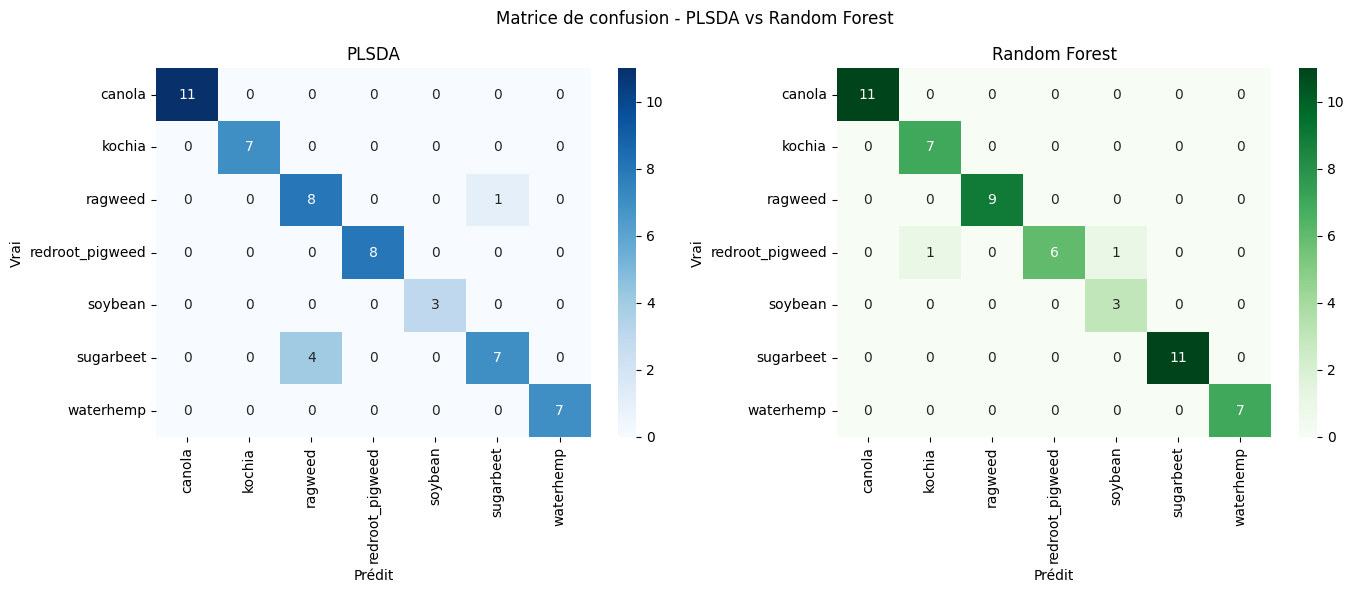

In [2]:
# COMPARAISON PLSDA vs RANDOM FOREST

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Chargement des données ---
df = pd.read_csv("C:/Users/sofia/OneDrive/Documents/GitHub/P_DM_UE3//data/combined_data.csv")

# --- Oversampling (comme fait précédemment) ---
from sklearn.utils import resample
majority_class = df[df['class'] == 'redroot_pigweed']
minority_classes = df[df['class'] != 'redroot_pigweed']

balanced_minority_list = []
for label in minority_classes['class'].unique():
    subset = minority_classes[minority_classes['class'] == label]
    upsampled = resample(subset, replace=True, n_samples=40, random_state=42)
    balanced_minority_list.append(upsampled)

df_balanced = pd.concat([majority_class] + balanced_minority_list)

# --- Préparation des données ---
X = df_balanced.drop(columns="class")
y = df_balanced["class"]

# Encodage one-hot de y pour la PLSDA
y_encoded = pd.get_dummies(y)

# Centrage et réduction de X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Séparation train/test ---
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Version labels simples pour la RF et l'évaluation
class_names = y_encoded.columns
y_train_labels = np.argmax(y_train_encoded.values, axis=1)
y_test_labels = np.argmax(y_test_encoded.values, axis=1)

# --- Modèle PLSDA (6 composantes) ---
pls = PLSRegression(n_components=6)
pls.fit(X_train, y_train_encoded)
y_pred_pls = pls.predict(X_test)
y_pred_pls_classes = np.argmax(y_pred_pls, axis=1)

# --- Modèle Random Forest ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train_labels)
y_pred_rf = rf.predict(X_test)

# --- Évaluation ---
acc_pls = accuracy_score(y_test_labels, y_pred_pls_classes)
acc_rf = accuracy_score(y_test_labels, y_pred_rf)

print(f"\n🎯 Accuracy PLSDA : {acc_pls:.2f}")
print(f"🎯 Accuracy Random Forest : {acc_rf:.2f}")

print("\n📋 Rapport PLSDA :")
print(classification_report(y_test_labels, y_pred_pls_classes, target_names=class_names))

print("\n📋 Rapport Random Forest :")
print(classification_report(y_test_labels, y_pred_rf, target_names=class_names))

# --- Matrices de confusion ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(confusion_matrix(y_test_labels, y_pred_pls_classes), annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=class_names, yticklabels=class_names)
axes[0].set_title("PLSDA")
axes[0].set_xlabel("Prédit")
axes[0].set_ylabel("Vrai")

sns.heatmap(confusion_matrix(y_test_labels, y_pred_rf), annot=True, fmt='d', cmap='Greens', ax=axes[1], xticklabels=class_names, yticklabels=class_names)
axes[1].set_title("Random Forest")
axes[1].set_xlabel("Prédit")
axes[1].set_ylabel("Vrai")

plt.suptitle("Matrice de confusion - PLSDA vs Random Forest")
plt.tight_layout()
plt.show()
